## Decision Tree

### Building Your Model
    The steps to building and using a model are:
    1.Define: What type of model will it be? A decision tree? Some other type of model? Some other parameters of the model type are specified too.
    2.Fit: Capture patterns from provided data. This is the heart of modeling.
    3.Predict: Just what it sounds like
    4.Evaluate: Determine how accurate the model's predictions are

### Underfitting & Overfitting
    1）Overfitting - Tree depth is too large, only a few of training data in each leaf causing unreliable predictions on new data
    2）Underfitting - Tree depth is too shallow, too large volume of training data in each leaf causing failure in capturing important distinctions and patterns on data

<img src=".\pic\underfitting_overfitting.png" width="50%" height="50%">

But the **max_leaf_nodes** argument provides a very sensible way to control overfitting vs underfitting. The more leaves we allow the model to make, the more we move from the underfitting area in the above graph to the overfitting area.
We can use a utility function to help compare MAE scores from different values for **max_leaf_nodes**

In [ ]:
from sklearn.metrics import mean_absolute_errorfrom sklearn.tree import DecisionTreeRegressor

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
mae = mean_absolute_error(val_y, preds_val)
return(mae)

We can use a for-loop to compare the accuracy of models built with different values for **max_leaf_nodes**.

In [ ]:
# compare MAE with differing values of max_leaf_nodesfor max_leaf_nodes in [5, 50, 500, 5000]:
my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
print("Max leaf nodes: %d \t\t Mean Absolute Error: %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5 Mean Absolute Error: 347380  

Max leaf nodes: 50 Mean Absolute Error: 258171  

Max leaf nodes: 500 Mean Absolute Error: 243495  

Max leaf nodes: 5000 Mean Absolute Error: 254983

## Random Forests

The random forest uses many trees, and it makes a prediction by **averaging the predictions of each component tree**. It generally has **much better predictive accuracy than a single decision tree** and it works well with default parameters. 
Random Forests can significantly solve over-fitting problem by  
    1.  Ensemble Learning - by combining multiple decision trees to make predictions by averaging out the errors and capture more representive patterns  
    2.  Random Feature Selection - each tree is built uing a random subset of features at each split preventing from memorizing noise

### Dealing with missing values

#### 1) A Simple Option: Drop Columns with Missing Values   
    Unless most values in the dropped columns are missing, the model loses access to a lot of (potentially useful!) information with this approach. 
#### 2) A Better Option: Imputation  
    Fill in missing values with mean/median/most_frequent/constant(replace with `fill_value`)  
    <class sklearn.impute.SimpleImputer>

#### 3) An Extension To Imputation  

    In this approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.

<img src=".\pic\imputation.png" width="50%" height="50%">

### Categorical Variables

#### 1) Drop Categorical Variables  
    The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.
#### 2) Ordinal Encoding  
    This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).
#### 3) One-Hot Encoding
    **One-hot encoding** creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

<img src=".\pic\one_host_encoding.png">

There are 2 ways to apply one-hot encoding:
- sklearn.preprocessing.OneHotEncoder
- pandas.get_dummies

In contrast to ordinal encoding, one-hot encoding does not assume an ordering of the categories. *Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data*   
One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than **15 different values**).

**Tips** Columns can vary after applying one-hot encoding to training set and validation set due to different categorial values presence.  
To align with training data and just drop the categories in validation data which not present in training data:  
`X_train, X_valid = X_train.align(X_valid, join='left', axis=1)`

#### tips - Ordinal Encoding
Fitting an ordinal encoder to a column in the training data creates a corresponding integer-valued label for each unique value that appears in the training data. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them.  
This is a common problem that you'll encounter with real-world data, and there are many approaches to fixing this issue. For instance, you can write a custom ordinal encoder to deal with new categories. The simplest approach, however, is to drop the problematic categorical columns.  
Run the code cell below to save the problematic columns to a Python list bad_label_cols. Likewise, columns that can be safely ordinal encoded are stored in good_label_cols.  abel_cols)

In [ ]:
###### Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

###### Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        # Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

### Pipelines
**1.Cleaner Code:** Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.  
**2.Fewer Bugs:** There are fewer opportunities to misapply a step or forget a preprocessing step.  
**3.Easier to Productionize:** It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.  
**4.More Options for Model Validation:** You will see an example in the next tutorial, which covers cross-validation.ion.on.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)
# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

### Cross-Validation

#### When should you use cross-validation?  
- if your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.
- Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment yields the same results, a single validation set is probably sufficient.

#### What is cross-validation?
In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 **"folds"**.

<img src=".\pic\cross_validation.png" />

In [ ]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5, #we set the number of folds with the cv parameter.
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

### XGBoost

**XGBoost** stands for **extreme gradient boosting**, which is an implementation of gradient boosting with several additional features focused on performance and speed. 

#### Parameter Tuning

**n_estimators** specifies how many times to go through the modeling cycle described above. `It is equal to the number of models that we include in the ensemble.`

- Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
- Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from **100-1000**, though this depends a lot on the **learning_rate** parameter discussed below.

**early_stopping_rounds** offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators.  
Setting early_stopping_rounds=5 is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

**learning_rate**
Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in.  
This means each tree we add to the ensemble helps us less. So, we can set a higher value for n_estimators without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.  
In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets learning_rate=0.1.

**n_jobs**
On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter `n_jobs equal to the number of cores` on your machine. On smaller datasets, this won't help.

`The resulting model won't be any better`, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.(`只是fit的时间变短了，并不影响model的准确度`)

In [ ]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

### Data Leakage

Data leakage (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

There are two main types of leakage: **target leakage** and **train-test contamination**.

#### 1. Target leakage ####

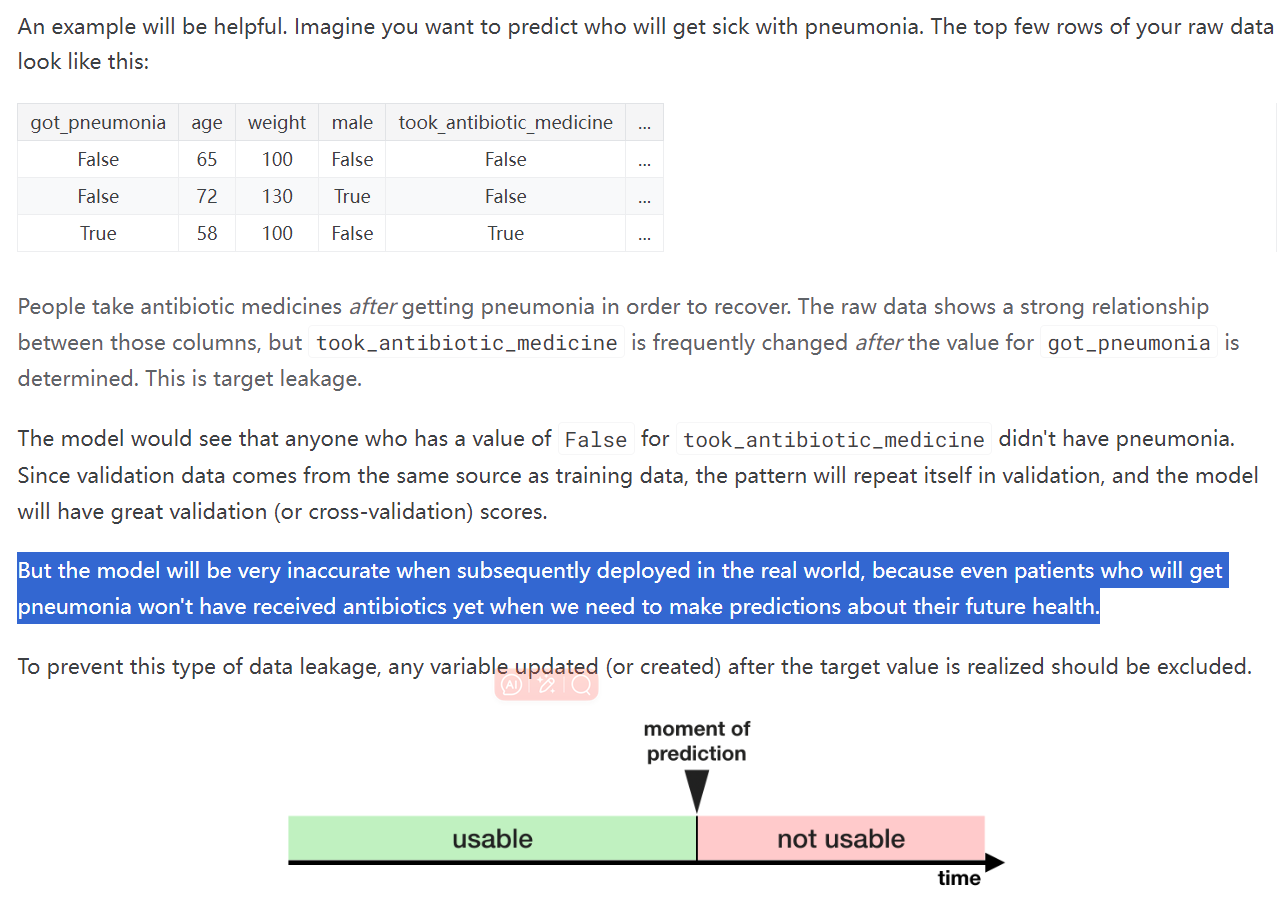

#### 2. Train-Test Contamination ####

Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.

For example, imagine you run preprocessing (like fitting an imputer for missing values) before calling train_test_split(). The end result? Your model may get good validation scores, giving you great confidence in it, but perform poorly when you deploy it to make decisions.  
就是说在train_test_split之前使用imputer使用mean value补充missing value了，这样是基于train和validate混合数据集计算的，之后分离的train和validate的数据是相互污染的。所以应该先分离test和validate数据集，再分离imputation.


In [ ]:
#Tips: 有一些对prediction预测影响很强的feature可能涉及signal leakage,比如评估歌曲popularity，
#其中artist是一个很关键的feature.我们可以考虑一个artist的歌曲全部出现在test dataset或train dataset，防止Train-Test Contamination. 那么在split的时候可以使用:

splitter = GroupShuffleSplit(train_size=train_size)train, test = next(splitter.split(X, y, groups=group))
return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])